# Introduction to `pandora-sim`

`pandora-sim` is a simulator for Pandora data that is currently under development. 

In [1]:
%matplotlib inline

In [2]:
import pandorasim as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from tqdm import tqdm
from astropy.io import fits
from pandorasim.utils import plot_nirda_integrations

## Obtaining Target Information

Suppose we want to simulate Pandora observations of the system GJ 436 system. Let's first use the built-in `Target` class to obtain information our target.

The `Target` class will soon move to another package in the Pandora software ecosystem, so check back frequently for the most up-to-date syntax.

In [3]:
target = ps.Target.from_gaia("GJ 436")

We can see that our `target` object now contains a lot of useful information about the system, such as the Right Ascension, Declination, Effective Temperatureof the host star, orbiting planets, and more. 

In [4]:
target.ra

<Quantity 175.55295298 deg>

In [5]:
target.dec

<Quantity 26.70110464 deg>

In [6]:
target.teff

<Quantity 3228.1418 K>

In [7]:
target.jmag

6.9

In [8]:
target.bmag

10.893038

In [9]:
target.planets

{'b': {'pl_orbper': <Quantity 2.64388312 d>,
  'pl_tranmid': <Quantity 2454510.80162 d>,
  'pl_trandur': <Quantity 1.00536 h>,
  'pl_trandep': <Quantity 0.6819 %>}}

To make simulations you'll need targets with information about the SED. Our `target` object already has this and we can plot this information using

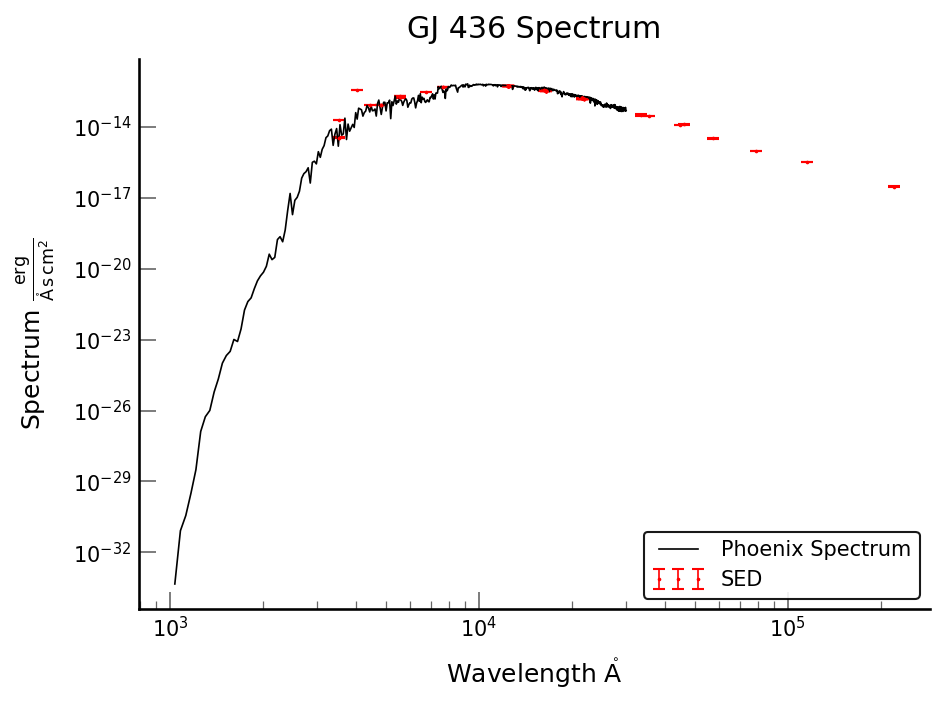

In [10]:
target.plot_spectrum();

We can also interpolate our spectrum to view it within a certain wavelength regime.

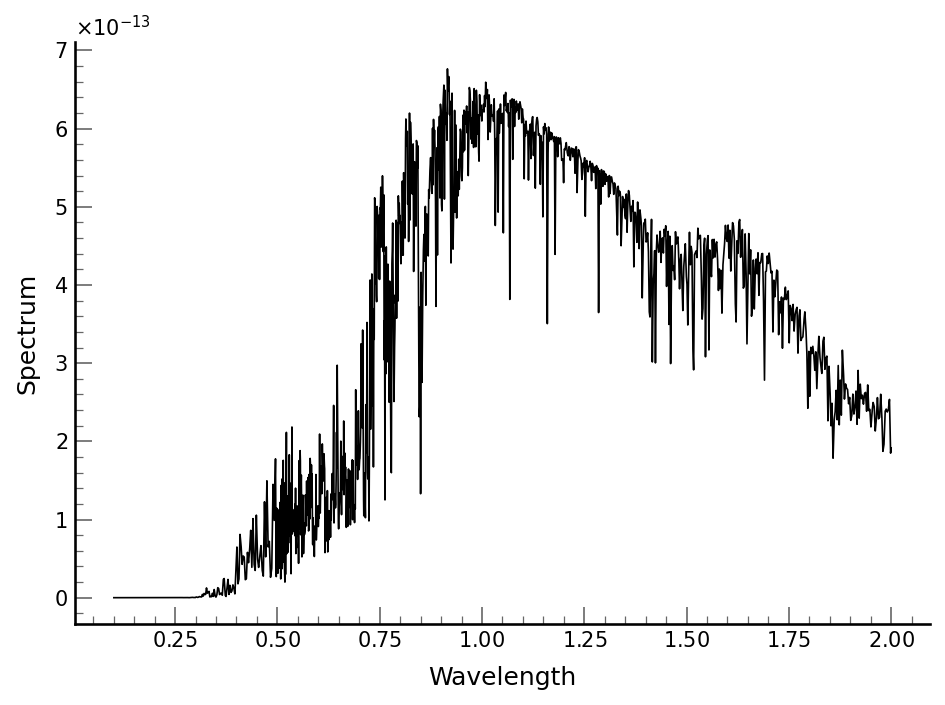

In [11]:
w = np.arange(0.1, 2, 0.0001) * u.micron
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(w, target.spectrum(w))
    ax.set(xlabel='Wavelength', ylabel='Spectrum');

It is also possible to access the SED with the `SED` property of our `target` object in order to manipulate it directly.

In [12]:
target.SED

{'wavelength': <Quantity [  3519.02124613,   3519.02124613,   3519.02124613,
              4020.01284613,   4442.02782634,   4819.96942024,
              4819.96942024,   5537.04925845,   5537.04925845,
              5537.04925845,   5537.04925845,   6729.95236385,
              7634.91208679,   7634.91208679,  12390.16606051,
             12390.16606051,  12390.16606051,  12390.16606051,
             12390.16606051,  12390.16606051,  12390.16606051,
             12390.16606051,  12390.16606051,  12500.20672977,
             12500.20672977,  12500.20672977,  16300.15539365,
             16300.15539365,  16494.77072902,  16494.77072902,
             16494.77072902,  16494.77072902,  16494.77072902,
             16494.77072902,  16494.77072902,  16494.77072902,
             16494.77072902,  21637.85333815,  21637.85333815,
             21637.85333815,  21637.85333815,  21637.85333815,
             21637.85333815,  21637.85333815,  21637.85333815,
             21637.85333815,  21637.85333

Our `target` class also allows us the ability to simulate what the transits of the planets contained in our system would look like. For now, we are restricted to using box-like transit shapes. In the future, however, this will be exanded to include the option to simulate more realistic transit shapes.

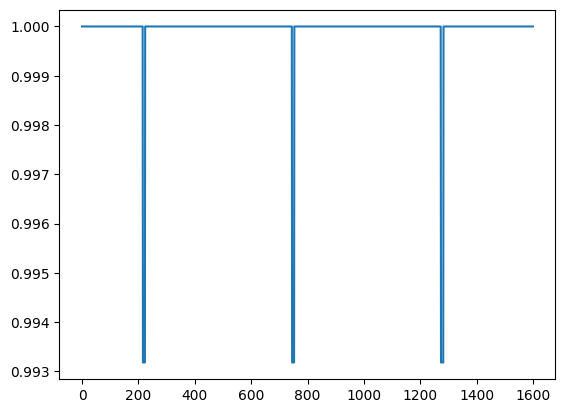

In [13]:
transit = target.box_transit(time=np.arange(0, 8, 0.005))
plt.plot(transit);

## Pandora Observatory

Now that we have information about our target, we can initialize the observatory using the `PandoraSim` class. The general workflow for using `pandora-sim` is as follows: point the observatory, set up some observations parameters, then obtain simulated output.

First, let's pick an observation duration and start time and set up the observatory. Note these are astropy quantities and times.

In [14]:
duration = 360*u.minute
obstime = Time(target.planets['b']['pl_tranmid'].value - (duration/2).to(u.day).value, format='jd')

Let's arbitrarily assume a roll angle of 10 degrees. Roll angle is dependent on the exact orbit which is not yet defined, so it's ok to arbitrarily choose for now. It's also possible to input any arbitrary RA, Dec, and roll angle here so it's not necessary to obtain the coordinates of a specific target using the `Target` class, but we're going to stick with the example of GJ 436.

In [15]:
p = ps.PandoraSim(ra=target.ra, dec=target.dec, theta=10*u.deg, duration=duration, obstime=obstime)

What is this doing?

* Setting up two subclasses to the observatory which are the NIRDA and VISDA
* Finding a catalog on sky at the correct location
* Applying a WCS with reasonable distortions to the catalog for each instrument


What is this NOT doing:

* Checking that your observation is possible (currently we have no information on the orbit of Pandora, so we can't tell if the observatory is behind the Earth). **We are not checking if there are timing constraints on this observation, or e.g. sun angle constraints.** For that you'll have to go to `pandora-scheduler` for now.

Now that we've set up the pointing of the observayory, let's plot the footprint of Pandora's VISDA and NIRDA detectors on our field of view with our target and background stars visible.

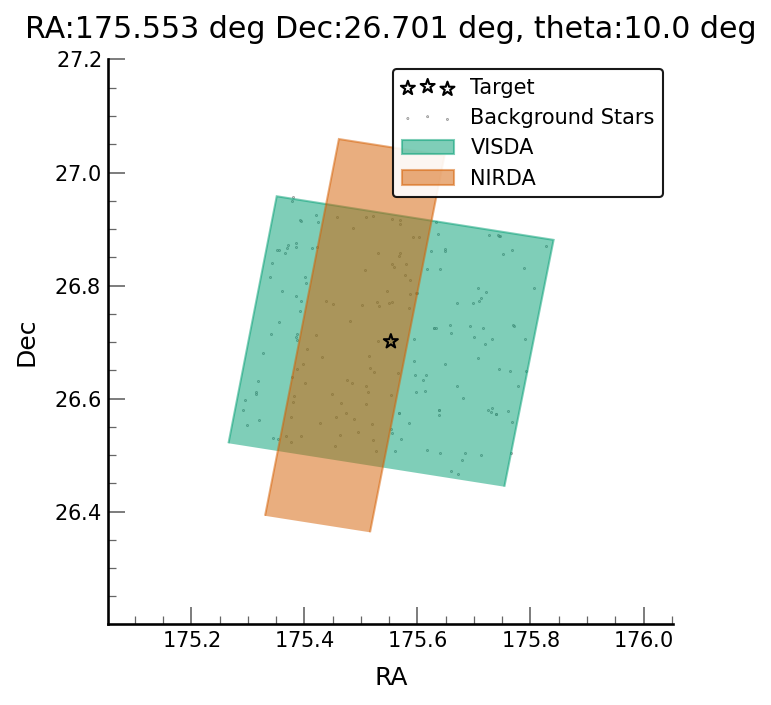

In [16]:
fig = p.plot_footprint();

We can break out the two detectors of the observatory individually if we want to access any of their specific functions more quickly.

In [17]:
nirda = p.NIRDA
visda = p.VISDA

## Basic Detector Properties

Since the NIRDA and VISDA classes in `pandora-sim` inherit all of the properties of their corresponding classes in `pandora-sat`, we can access all of the values contained in pandora-sat easily through `pansora-sim` using the same syntax.

We can start by checking the sensitivity of the two detectors.

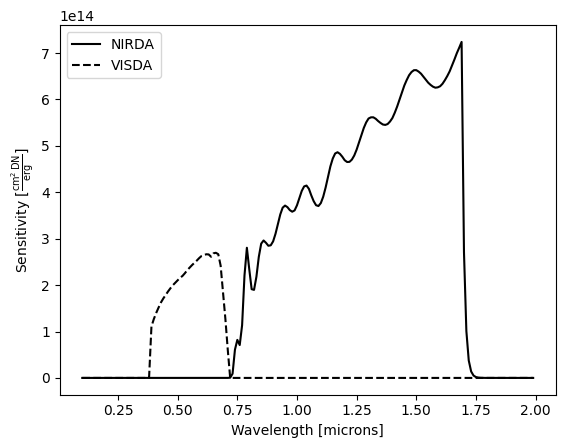

In [18]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend();

We can also estimate the flux/magnitude of a source

In [19]:
nirda.flux_from_mag(10)

<Quantity 3.41062868e-14 erg / (Angstrom s cm2)>

In [20]:
visda.flux_from_mag(10)

<Quantity 3.77670343e-13 erg / (Angstrom s cm2)>

In [21]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.8320861>

In [22]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.44278221>

Or access many of the pointing-independent properties of the detectors, including the dark current and the read noise, among other properties. See the `pandora-sat` documentation for a full list of accessible properties.

In [23]:
visda.dark

<Quantity 1. electron / s>

In [24]:
visda.read_noise

<Quantity 1.5 electron>

It's also possible for us to take a look at the PSFs and PRFs for each detector with the `diagnose` function. This functionality will likely change over time as the code is transferred over to the `pandora-psf` package, so check back frequently for updates.

Let's take a look at the PSFs and PRFs for NIRDA first

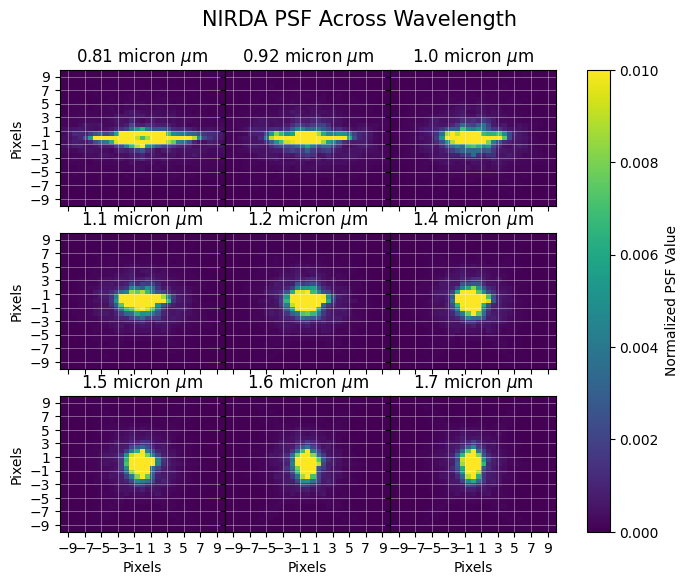

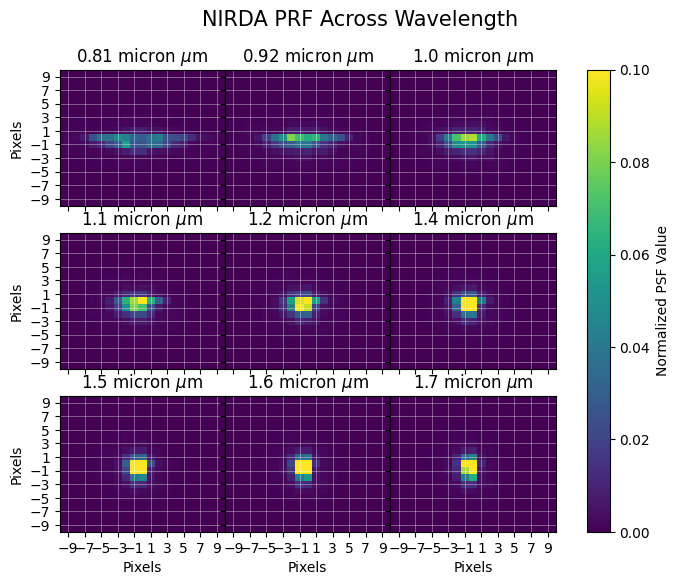

In [25]:
nirda.diagnose(n=3, image_type='psf');
nirda.diagnose(n=3, image_type='prf');

And now for VISDA

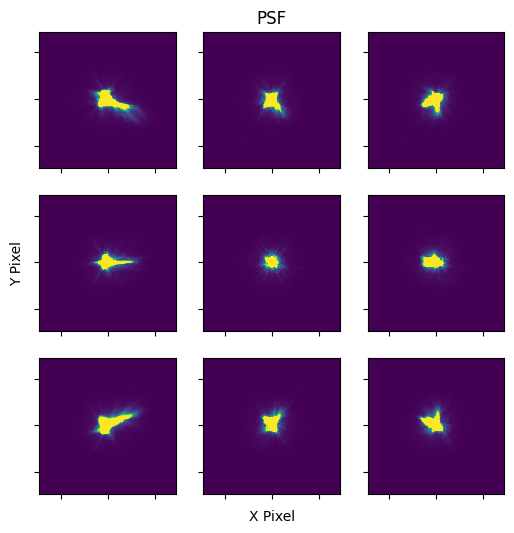

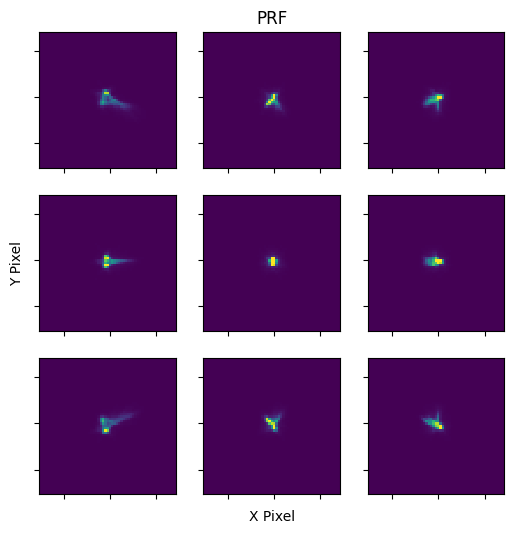

In [26]:
visda.diagnose(n=3, image_type='psf');
visda.diagnose(n=3, image_type='prf');

## Making Visible Image Simulations

Now that we have our observatory pointed and set up for observing, we can make some visible image simulations. To do this we need to get the sky catalog for the sky around our target. Luckily, our `PandoraSim` object queried Gaia DR3 within the bounds of the visible detector upon initialization. This is saved as the `SkyCatalog` property of our object. It is also possible to query the nearby field using the `get_sky_catalog` method to obtain a standalone source catalog.

In [27]:
p.SkyCatalog

ra        dec        mag      vis_row   vis_column      nir_row  \
0    175.552953  26.701105  10.893038  1022.999849  1023.000000  1022.999945   
1    175.530954  26.702659  15.576467  1014.206117  1113.573919  1017.171965   
2    175.593817  26.704698  16.582132  1068.178051   859.949373  1052.392371   
3    175.513437  26.674721  18.370363   874.305179  1162.339714   925.223523   
4    175.594439  26.666198  15.941728   893.362163   826.533263   937.604645   
..          ...        ...        ...          ...          ...          ...   
176  175.298994  26.552678  18.265965   145.320282  1936.649144   435.288967   
177  175.764797  26.503807  14.977934   256.327501     3.351198   507.815642   
178  175.377808  26.949021  18.195177  1999.516649  1932.732819  1650.050845   
179  175.380410  26.956779  18.350275  2035.726325  1928.399262  1673.345424   
180  175.828150  26.870705  19.824865  1965.107505    41.931543  1626.932244   

     nir_column     vis_counts      vis_flux    jmag         teff    logg  \
0     79.000000  115501.968750  1.659196e-13   6.900  3228.141846  4.0089   
1    138.367823    1546.029907  2.220886e-15  13.654  4854.255859  4.4883   
2    -27.879241     612.282104  8.795488e-16  15.038  5404.709473  4.4928   
3    170.325687     117.939484  1.694211e-16  15.535  3844.972412  4.8407   
4    -49.770887    1104.367065  1.586433e-15  14.571  5580.291504  4.5011   
..          ...            ...           ...     ...          ...     ...   
176  678.277607     129.843048  1.865207e-16  13.880  3389.384521  4.8999   
177 -589.872505    2683.063477  3.854245e-15  13.273  5228.775391  4.6086   
178  676.493514     138.590576  1.990866e-16  14.142  3429.619141  4.6629   
179  673.688492     120.141899  1.725849e-16  15.258  3821.009521  4.7834   
180 -565.369283      30.892879  4.437790e-17  15.524          NaN     NaN   

         ruwe   ang_sep  
0    1.125377  0.002749  
1    1.026066  0.019683  
2    0.951376  0.036683  
3    1.046657  0.044062  
4    1.051605  0.050819  
..        ...       ...  
176  1.016730  0.271211  
177  1.104241  0.273485  
178  1.046936  0.292993  
179  1.077752  0.298414  
180  1.073302  0.298548  

[181 rows x 14 columns]

In [28]:
len(p.SkyCatalog)

181

Now we have everything we need to make an image of the sky on the visible camera. We can use the `get_FFIs` method of our `PandoraSim` object to generate this simulated observation. In this method, we can specify whether we want to include simulated noise, simulated cosmic rays, the number of detector integrations coadded to make the frame, and whether to identify nearby single stars with the Pandora visible subarray projected onto them. By default, the `make_subarrays` flag is set to True, so the subarray regions of interest (ROIs) will also be made.

The nearby stars identified are included in order of expected visible detector counts, selecting the target plus the eight brightest background targets. It's important to note that targets with a RUWE > 1.2 are not included. The nearest 8 ROIs are included in addition to the target.

In [29]:
p.get_FFIs(nreads=10, include_noise=True, include_cosmics=True)

We can now plot the FFI we just generated to see what it lookes like. By default, if you generated ROIs along with the FFIs, those subarray footprints will be plotted as well.

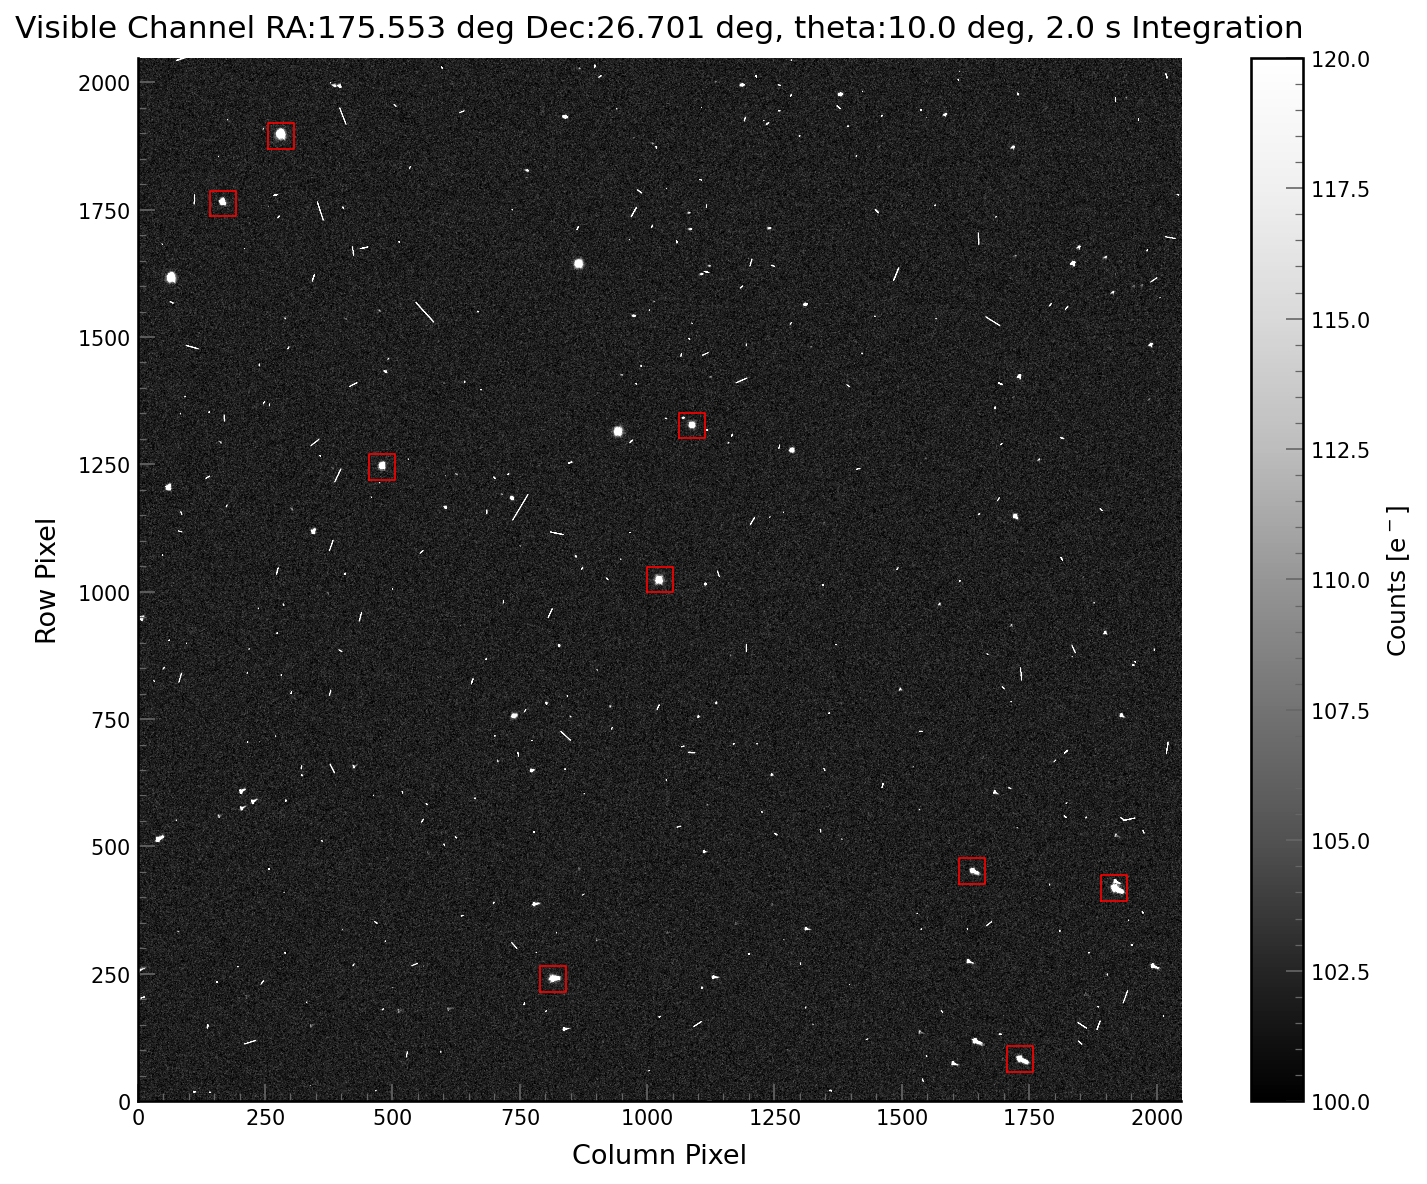

In [30]:
p.plot_FFI();

We can see that our target GJ 436 is right in the center of the visible detector and the positions of a few nearby single Gaia stars are also framed within boxes representing Pandora's visible subarray. With this, we can plot the target pixel files (TPFs) for our target and some nearby bright stars. The TPFs are just the cutouts from the FFIs within out ROIs.

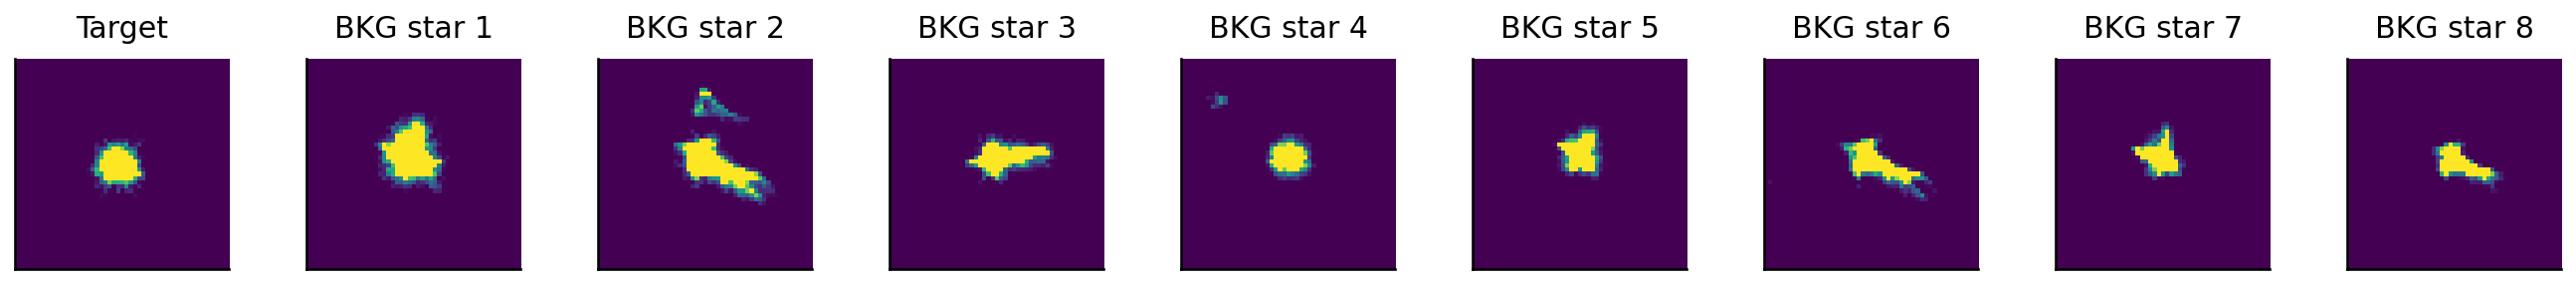

In [31]:
p.VISDA.plot_TPFs();

Now let's say that we want to save our FFIs and ROIs as FITS files for use later. To do this, we can use the `PandoraSim` method `save_visda`. Let's save the FFIs we generated first. We're going to specify a filename here that will save in our current directory for demonstration purposes, but the default filename conforms to the Pandora ICD.

In [32]:
ffis_outfile = 'example_ffis.fits'
p.save_visda(outfile=ffis_outfile)

And with that, we've saved our file! Let's load it in and take a look at what it contains.

In [33]:
hdul_ffis = fits.open(ffis_outfile)
print(hdul_ffis.info())

Filename: example_ffis.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        12   (2048, 2048, 1)   float64   
None


We can see that we've got two FITS file extensions: one primary with some information about the simulated observation and another with information about the data. Let's also open up the data and plot it just to check that it looks like the plotted FFI above.

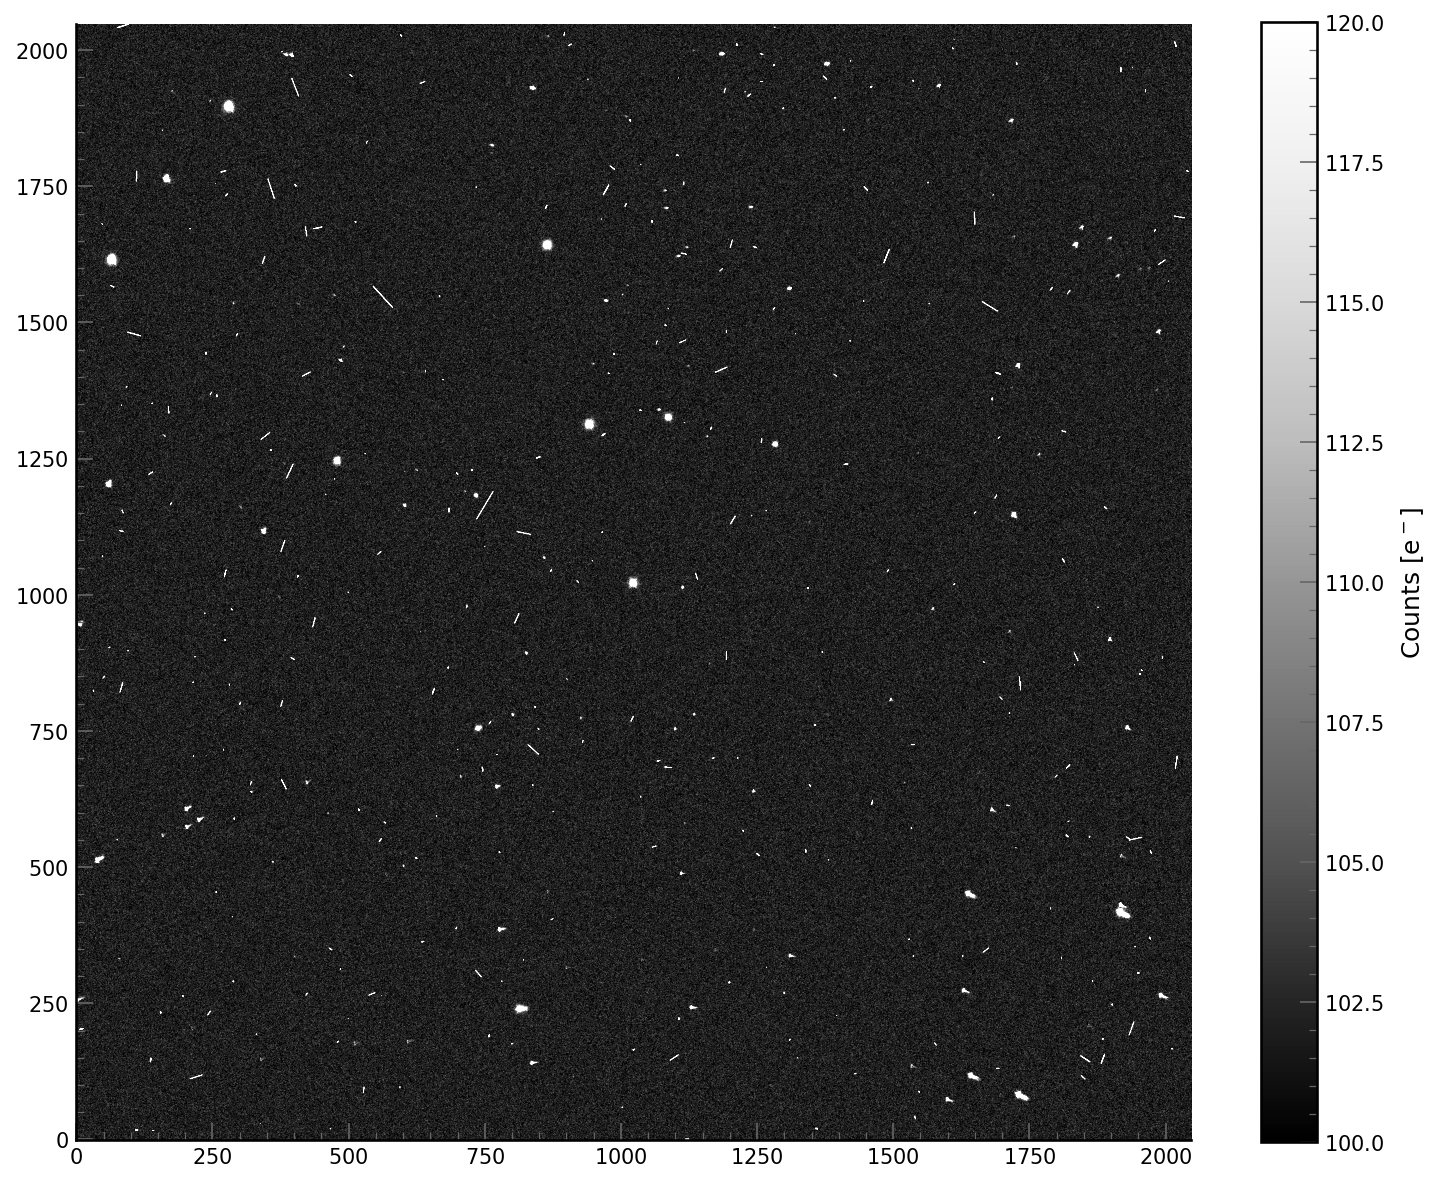

In [34]:
with plt.style.context(ps.PANDORASTYLE):
    vmin = p.VISDA.bias.value
    vmax = p.VISDA.bias.value + 20
    cmap = "Greys_r"
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(
        hdul_ffis[1].data[0],
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # **kwargs,
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Counts [e$^-$]", fontsize=12);

Looking good! Now let's repeat the procedure with our ROIs and take a look at how they're formatted. We can again use the same `save_visda` method, but this time specifying `rois=True`. The ROIs were generated at the same time as the FFIs above as part of the `get_FFIs` method.

In [35]:
rois_outfile = 'example_rois.fits'
p.save_visda(outfile=rois_outfile, rois=True)

In [36]:
hdul_rois = fits.open(rois_outfile)
print(hdul_rois.info())

Filename: example_rois.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        12   (153, 150, 1)   int64   
  2  ROITABLE      1 BinTableHDU     22   9R x 2C   [K, K]   
None


As you can see here, we have not only the `PRIMARY` and `SCIENCE` extension like with the FFIs, but we now also have an extension called `ROITABLE`. This extension contains the VISDA pixel coordinates of the origin of the subarray, which is defined as the lower left corner. Let's plot the data contained within the `SCIENCE` extension.

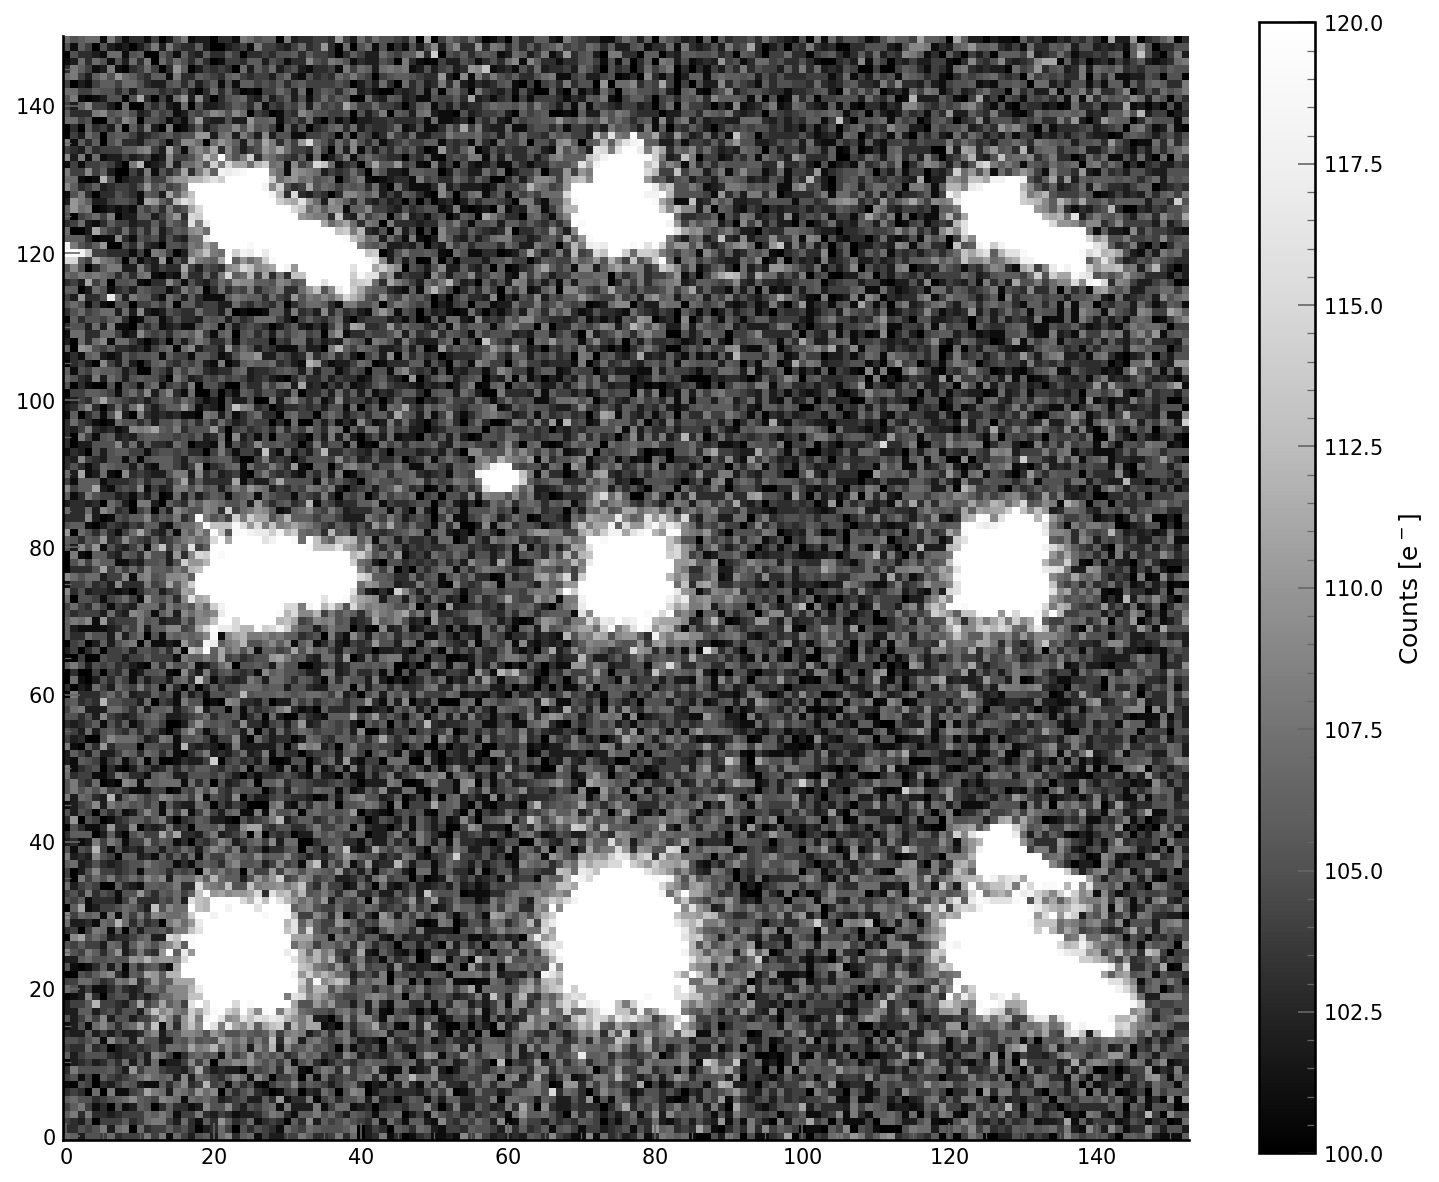

In [37]:
with plt.style.context(ps.PANDORASTYLE):
    vmin = p.VISDA.bias.value
    vmax = p.VISDA.bias.value + 20
    cmap = "Greys_r"
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(
        hdul_rois[1].data[0],
        origin="lower",
        # origin = 'upper',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # **kwargs,
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Counts [e$^-$]", fontsize=12);

Instead of a full frame image, we see a mosaic of all of the ROIs laid out in a grid pattern. Starting with the target in the lower left corner, the sequence of ROIs proceed from left to right, from bottom to top (in ascending X and Y coordinates).

Let's also output the data contained in the `ROITABLE` extension.

In [38]:
print(hdul_rois[2].data)

[( 999,  999) (1870,  256) ( 393, 1892) ( 215,  789) (1301, 1062)
 (1220,  454) (  58, 1706) (1737,  142) ( 427, 1613)]


As you'll see, this extension contains pairs of coordinates in (row, column) format. This data can be interacted with like a regular array.

# Making realistic data simulations

We can turn our TPFs into simulated data as well. Let's select the TPF for our target and use the `get_target_timeseries` method to generate a time series for our observation.

In [39]:
time, flux = p.VISDA.get_target_timeseries(ts_func=target.box_transit, subarray=0)

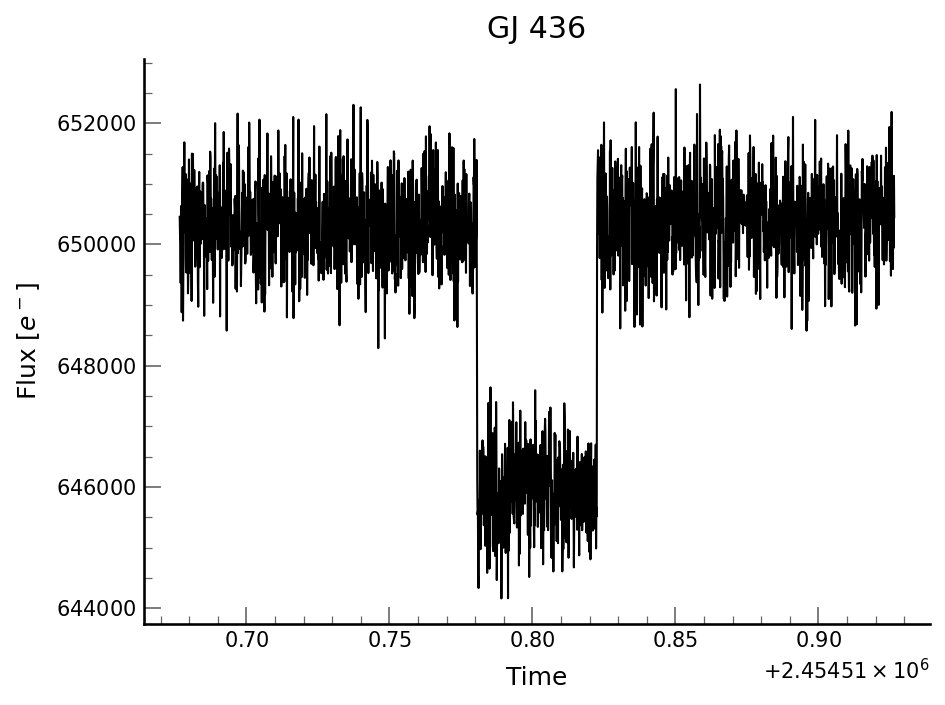

In [40]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(time, flux, c='k', lw=1)
    ax.set(xlabel='Time', ylabel='Flux [$e^-$]', title=target.name)

This is injecting the target flux at the pixel level in the PSF from LLNL, alongside background stars from the Gaia catalog with reasonable Pandora flux. We have reasonable noise estimates from what we know about the detector. (Note: these estimates will *update* so make sure to *update* `pandora-sim` frequently!)

This does **not** currently have expected jitter in it, but will include this soon. Adding jitter drastically slows down the simulation so some clever thinking is necessary.

## Getting a NIRDA Trace

Here we're using "trace" to mean the spectrum dispersed onto the detector. This has some thickness to it.

To make a NIRDA trace we're going to use this fast trace function. This is definitely going to change, and will be wrapped up in a nice function in the future.

In [41]:
wav_edges, fasttrace = p.NIRDA.get_fasttrace(sub_res=9, npix=2)

Building fasttrace:   0%|          | 0/9 [00:00<?, ?it/s]

Building fasttrace: 100%|██████████| 9/9 [02:04<00:00, 13.85s/it]


We need to know where the source falls on the detector, this function will include expected distortions

In [42]:
row, col = p.NIRDA.world_to_pixel(p.ra, p.dec)[:, 0]

We need to integrate the spectrum across the sensitivity, and calculate the integrated spectrum at each wavelength element

In [43]:
integral = p.NIRDA.get_integrated_spectrum(w, target.spectrum(w), wav_edges, plot=True)

Then we can calculate the "trace" at that point

In [44]:
r, c, prf = fasttrace(row, col)
trace = (integral[:, None, None] * prf).sum(axis=0)

If we plot the integral compared with the trace, we see that the PSF blurs out the features in wavelength.

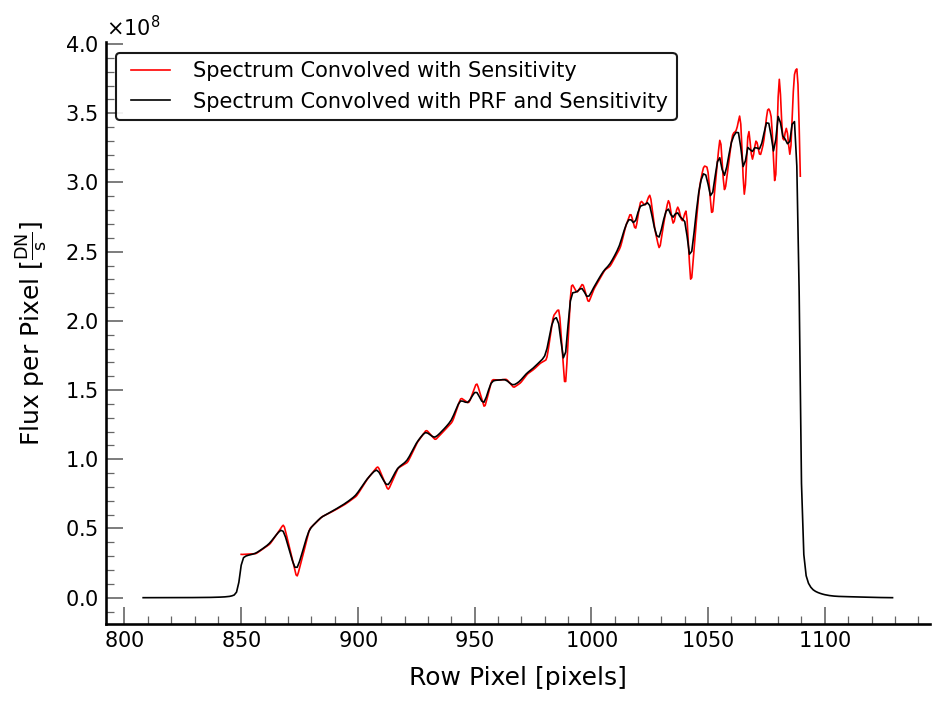

In [45]:
npix = 2
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    w1 = p.NIRDA.wavelength_to_pixel(wav_edges.mean(axis=1) * u.micron).value + row
    ax.plot(w1, integral * npix, label='Spectrum Convolved with Sensitivity', c='r')
    ax.plot(r, trace.sum(axis=1), c='k', label='Spectrum Convolved with PRF and Sensitivity')
    ax.set(xlabel=f"Row Pixel [pixels]", ylabel=f"Flux per Pixel [{integral.unit.to_string('latex')}]")
    ax.legend(frameon=True)

Here we can see the trace as an image

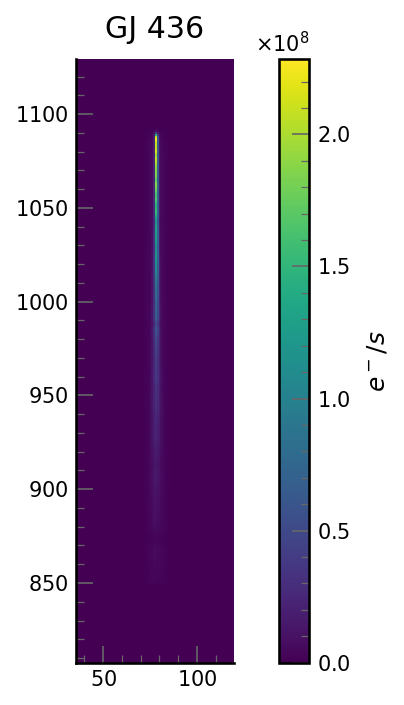

In [46]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    plt.pcolormesh(c, r, trace.value, cmap='viridis')
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar()
    cbar.set_label('$e^-/s$')
    ax.set(title=f'{target.name}')

However we need to include extra targets from the background.

In [47]:
from pandorasim.utils import get_phoenix_model

In [48]:
integrals = []
for idx, c in tqdm(p.NIRDA.Catalog.iterrows(), total=len(p.NIRDA.Catalog), desc='Calculating Star Integrals'):
    w, s = get_phoenix_model(teff=c.teff if np.isfinite(c.teff) else 5777, 
                             logg=c.logg if np.isfinite(c.logg) else 4.5,
                             jmag=c.jmag)
    integrals.append(p.NIRDA.get_integrated_spectrum(w, s, wav_edges, plot=True) * p.NIRDA.frame_time)

Calculating Star Integrals:   0%|          | 0/5 [00:00<?, ?it/s]/var/folders/mz/nhvk2jl54z1ds10j_hr_85lrssp60j/T/ipykernel_31922/3326944043.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  integrals.append(p.NIRDA.get_integrated_spectrum(w, s, wav_edges, plot=True) * p.NIRDA.frame_time)
Calculating Star Integrals:  20%|██        | 1/5 [00:00<00:01,  3.97it/s]/var/folders/mz/nhvk2jl54z1ds10j_hr_85lrssp60j/T/ipykernel_31922/3326944043.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  integrals.append(p.NIRDA.get_integrated_spectrum(w, s, wav_edges, plot=True) * p.NIRDA.frame_time)
Calculating Star Integrals:  40%|████      | 2/5 [00:00<00:00,  4.28it/s]/var/folders/mz/nhvk2jl54z1ds10j_hr_85lrssp60j/T/ipykernel_31922/3326944043.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumP

In [49]:
corner = p.NIRDA.subarray_corner
size = p.NIRDA.subarray_size
R, C = p.NIRDA.subarray_row, p.NIRDA.subarray_column
s = np.zeros(p.NIRDA.subarray_size)
cat = p.NIRDA.Catalog
for i, r1, c1 in zip(integrals, np.asarray(cat.nir_row), np.asarray(cat.nir_column)):
    r, c, prf = fasttrace(r1, c1)
    subtrace = (i[:, None, None] * prf).sum(axis=0)
    ok1 = (((r - corner[0]) >= 0) & ((r - corner[0]) < size[0]))[:, None] & ((c - corner[1]) >= 0) & ((c - corner[1]) < size[1])
    ok2 = np.in1d(R[:, 0],  r)[:, None] & np.in1d(C[0],  c) 
    s[ok2] += subtrace.value[ok1]
s = p.NIRDA.apply_gain(s*u.DN)

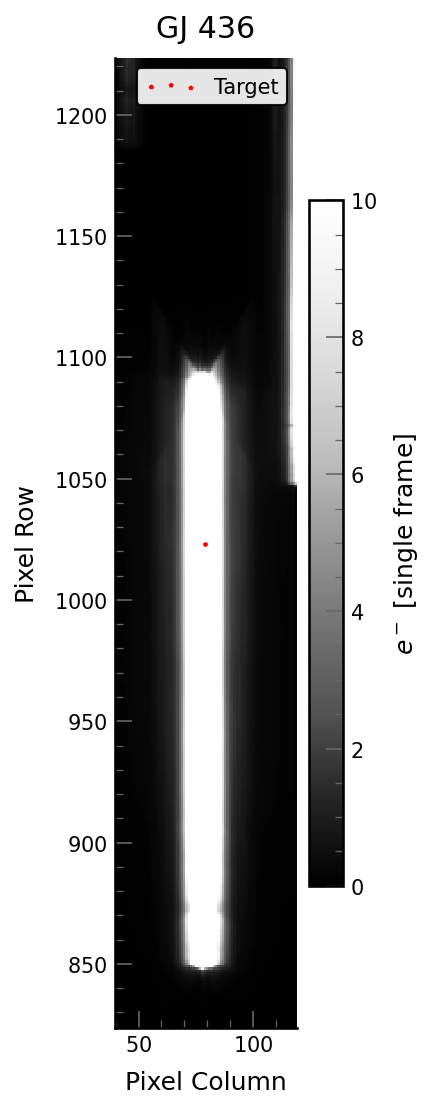

In [50]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots(figsize=(3, 1.5 * np.divide(*p.NIRDA.subarray_size)))
    im = ax.pcolormesh(p.NIRDA.subarray_column, p.NIRDA.subarray_row, s, vmin=0, vmax=10, cmap='Greys_r')
    ax.scatter(*p.NIRDA.world_to_pixel(p.NIRDA.ra, p.NIRDA.dec).T[0][::-1], c='r', marker='*', label='Target')
    ax.legend(frameon=True)
    ax.set(xlabel='Pixel Column', ylabel='Pixel Row',title=target.name)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('$e^-$ [single frame]')

And there's the NIRDA trace of our target!

We can also plot a simulated NIRDA integration scheme using the `utils.plot_nirda_integrations` function. Let's specify a few values and plot up an integration scheme for ourselves.

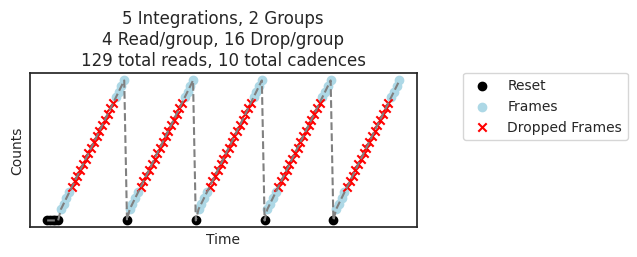

In [51]:
SC_Resets1 = 5
SC_Resets2 = 1
SC_DropFrames1 = 0
SC_DropFrames2 = 16
SC_DropFrames3 = 0
SC_ReadFrames = 4
SC_Groups = 2
SC_Integrations = 5

plot_nirda_integrations(
    SC_Resets1,
    SC_Resets2,
    SC_DropFrames1,
    SC_DropFrames2,
    SC_DropFrames3,
    SC_ReadFrames,
    SC_Groups,
    SC_Integrations,
);

In [52]:
out = p.get_nirda_stars()

In [53]:
type(out)

pandas.core.frame.DataFrame